Data Analysis


In [1]:
# ============================================
# Cell 1 — Preflight: load, clean, empirical arrays
# ============================================
import numpy as np
import pandas as pd

# ---- 1) Load your dataset (adjust path/name if needed) ----
df = pd.read_excel("01 Call-Center-Dataset.xlsx")

# ---- 2) Minimal cleaning & conversions ----
# Resolved -> binary
if 'Resolved' in df.columns:
    df['Resolved'] = df['Resolved'].astype(str).str.upper().str.strip().map({'Y':1, 'N':0}).fillna(0).astype(int)
else:
    # If missing, assume unresolved=0 (can change if your data differs)
    df['Resolved'] = 0

# Helper: convert time-like columns to minutes
def to_minutes(s: pd.Series) -> pd.Series:
    s = s.copy()
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce").astype(float)
    if pd.api.types.is_timedelta64_dtype(s):
        return s.dt.total_seconds()/60.0
    # Try HH:MM:SS
    dt = pd.to_datetime(s, errors="coerce", format="%H:%M:%S", exact=False)
    if dt.notna().any():
        return (dt.dt.hour*60 + dt.dt.minute + dt.dt.second/60.0).astype(float)
    # Fallback: parse as timedelta string
    td = pd.to_timedelta(s.astype(str), errors="coerce")
    return td.dt.total_seconds()/60.0

# ServiceMinutes: prefer 'ServiceMinutes' column, else fallback to 'AvgTalkDuration'
if 'ServiceMinutes' in df.columns:
    df['ServiceMinutes'] = to_minutes(df['ServiceMinutes'])
elif 'AvgTalkDuration' in df.columns:
    df['ServiceMinutes'] = to_minutes(df['AvgTalkDuration'])
else:
    # If neither exists, we must infer later; create a placeholder with NaN for now
    df['ServiceMinutes'] = np.nan

# Drop minimal critical nulls
critical_cols = ['Agent','Topic','Resolved','ServiceMinutes']
present = [c for c in critical_cols if c in df.columns]
df_cleaned = df.dropna(subset=present).copy()

# ---- 3) Empirical arrays (use your prior KM samples if already computed) ----
# If you already have: empirical_service_times / patience / interarrival defined in your notebook,
# this block will respect them and NOT overwrite.
if 'empirical_service_times' not in globals():
    empirical_service_times = df_cleaned['ServiceMinutes'].dropna().values

if 'empirical_patience_times' not in globals():
    # If patience isn’t in dataset, create a realistic proxy (Weibull-like, clipped)
    # Feel free to swap in your KM-derived patience array here.
    size = max(1000, len(df_cleaned))
    empirical_patience_times = np.clip(np.random.weibull(1.6, size=size)*6.0, 0.5, 120.0)

if 'empirical_interarrival_times' not in globals():
    # If inter-arrival isn’t in dataset, create a realistic proxy (Exponential, clipped)
    size = max(1000, len(df_cleaned))
    empirical_interarrival_times = np.clip(np.random.exponential(scale=2.0, size=size), 0.2, 60.0)

print("=== Preflight ready ===")
print("Data:", df.shape, "| Cleaned:", df_cleaned.shape)
print("Empirical arrays -> service:", len(empirical_service_times),
      "patience:", len(empirical_patience_times),
      "interarrival:", len(empirical_interarrival_times))



=== Preflight ready ===
Data: (5000, 11) | Cleaned: (4054, 11)
Empirical arrays -> service: 4054 patience: 4054 interarrival: 4054


=== Agent × Topic — Smoothed Resolution Rate (Laplace α=1, β=1) ===


Topic,Admin Support,Contract related,Payment related,Streaming,Technical Support
Agent,,,,,
Becky,0.892,0.888,0.877,0.876,0.901
Dan,0.910,0.893,0.870,0.879,0.915
Diane,0.945,0.883,0.869,0.882,0.888
Greg,0.888,0.913,0.926,0.894,0.870
Jim,0.907,0.902,0.854,0.885,0.933
Joe,0.926,0.884,0.902,0.869,0.885
Martha,0.894,0.908,0.909,0.822,0.913
Stewart,0.844,0.853,0.856,0.918,0.940



=== Agent × Topic — Call Counts ===


Topic,Admin Support,Contract related,Payment related,Streaming,Technical Support
Agent,,,,,
Becky,100,87,112,119,99
Dan,87,101,106,114,115
Diane,108,92,97,108,96
Greg,105,90,106,111,90
Jim,116,121,94,102,103
Joe,93,84,100,105,102
Martha,92,107,108,105,102
Stewart,94,107,95,83,98



=== Per-agent Overall Performance (smoothed) ===


,Agent,resolved,count,rate
0,Greg,455,502,0.905
1,Jim,485,536,0.903
2,Diane,452,501,0.901
3,Joe,436,484,0.899
4,Dan,471,523,0.899
5,Martha,461,514,0.895
6,Becky,462,517,0.892
7,Stewart,424,477,0.887



=== Top Agents by Topic (ranked by smoothed rate, tie-break on count) ===


,Topic,Rank,Agent,Rate,Count,Resolved
0,Admin Support,1,Diane,0.945455,108,103
1,Admin Support,2,Joe,0.926316,93,87
2,Admin Support,3,Dan,0.910112,87,80
3,Admin Support,4,Jim,0.906780,116,106
4,Admin Support,5,Martha,0.893617,92,83
5,Admin Support,6,Becky,0.892157,100,90
6,Admin Support,7,Greg,0.887850,105,94
7,Admin Support,8,Stewart,0.843750,94,80
8,Contract related,1,Greg,0.913043,90,83
9,Contract related,2,Martha,0.908257,107,98


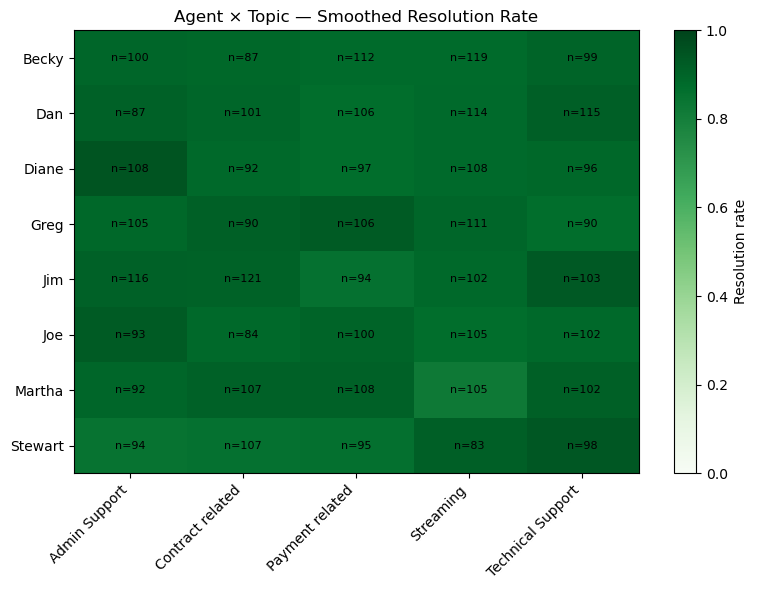

In [13]:
# ============================================
# Cell — Agent × Problem (Topic) Performance Matrix
# - Inputs: df_cleaned with columns ['Agent','Topic','Resolved'] (Resolved in {0,1})
# - Outputs:
#     perf_rate   : pivot (Agent x Topic) of smoothed resolution rates
#     perf_count  : pivot (Agent x Topic) of call counts
#     perf_both   : tidy table with columns [Agent, Topic, resolved, count, rate]
#     agent_overall: per-agent overall rate & calls
#     top_agents_by_topic: for each Topic, agents ranked by rate (with count)
# - Options: toggle heatmap rendering
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Safety checks ---
_required_cols = {'Agent','Topic','Resolved'}
if not _required_cols.issubset(set(df_cleaned.columns)):
    raise RuntimeError(f"df_cleaned must contain columns: {_required_cols}. Found: {df_cleaned.columns.tolist()}")

# --- Config ---
ALPHA, BETA = 1.0, 1.0   # Laplace smoothing: rate = (resolved+ALPHA)/(count+ALPHA+BETA)
MIN_CALLS_FOR_ANNOT = 5  # for heatmap annotation visibility
SHOW_HEATMAP = True

# --- Aggregate raw counts ---
agg = (
    df_cleaned
    .groupby(["Agent","Topic"], dropna=False)["Resolved"]
    .agg(resolved="sum", count="count")
    .reset_index()
)

# --- Smoothed rate ---
agg["rate"] = (agg["resolved"] + ALPHA) / (agg["count"] + ALPHA + BETA)

# --- Pivots for display ---
perf_rate  = agg.pivot(index="Agent", columns="Topic", values="rate").fillna(np.nan)
perf_count = agg.pivot(index="Agent", columns="Topic", values="count").fillna(0).astype(int)

# Tidy table (handy for CSVs or further processing)
perf_both = agg.sort_values(["Topic","rate"], ascending=[True, False]).reset_index(drop=True)

# --- Per-agent overall performance ---
agent_overall = (
    df_cleaned.groupby("Agent")["Resolved"]
    .agg(resolved="sum", count="count")
    .reset_index()
)
agent_overall["rate"] = (agent_overall["resolved"] + ALPHA) / (agent_overall["count"] + ALPHA + BETA)
agent_overall = agent_overall.sort_values("rate", ascending=False).reset_index(drop=True)

# --- Top agents per topic (ranked by smoothed rate; ties broken by count) ---
top_rows = []
for topic, sub in agg.groupby("Topic"):
    sub = sub.sort_values(["rate","count"], ascending=[False, False])
    for rank, r in enumerate(sub.itertuples(index=False), start=1):
        top_rows.append({
            "Topic": topic,
            "Rank": rank,
            "Agent": r.Agent,
            "Rate": r.rate,
            "Count": int(r.count),
            "Resolved": int(r.resolved),
        })
top_agents_by_topic = pd.DataFrame(top_rows)

# --- Display: tables ---
print("=== Agent × Topic — Smoothed Resolution Rate (Laplace α=1, β=1) ===")
display(perf_rate.style.format("{:.3f}").background_gradient(cmap="Greens", axis=None))

print("\n=== Agent × Topic — Call Counts ===")
display(perf_count)

print("\n=== Per-agent Overall Performance (smoothed) ===")
display(agent_overall.style.format({"rate":"{:.3f}"}))

print("\n=== Top Agents by Topic (ranked by smoothed rate, tie-break on count) ===")
display(top_agents_by_topic)

# --- Optional: Heatmap of rates with count annotations (lightweight) ---
if SHOW_HEATMAP and perf_rate.size > 0:
    fig, ax = plt.subplots(figsize=(max(8, perf_rate.shape[1]*0.8), max(6, perf_rate.shape[0]*0.4)))
    im = ax.imshow(perf_rate.values, aspect="auto", cmap="Greens", vmin=0, vmax=1)
    ax.set_xticks(range(perf_rate.shape[1])); ax.set_xticklabels(perf_rate.columns, rotation=45, ha="right")
    ax.set_yticks(range(perf_rate.shape[0])); ax.set_yticklabels(perf_rate.index)
    ax.set_title("Agent × Topic — Smoothed Resolution Rate")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Resolution rate")

    # annotate with counts (only when calls >= threshold to avoid clutter)
    counts_vals = perf_count.values
    for i in range(perf_rate.shape[0]):
        for j in range(perf_rate.shape[1]):
            n = counts_vals[i, j]
            if n >= MIN_CALLS_FOR_ANNOT:
                ax.text(j, i, f"n={n}", ha="center", va="center", fontsize=8, color="black")
    ax.grid(False)
    plt.tight_layout()
    plt.show()

# --- (Optional) Export CSVs ---
# perf_both.to_csv("agent_topic_performance_long.csv", index=False)
# agent_overall.to_csv("agent_overall_performance.csv", index=False)


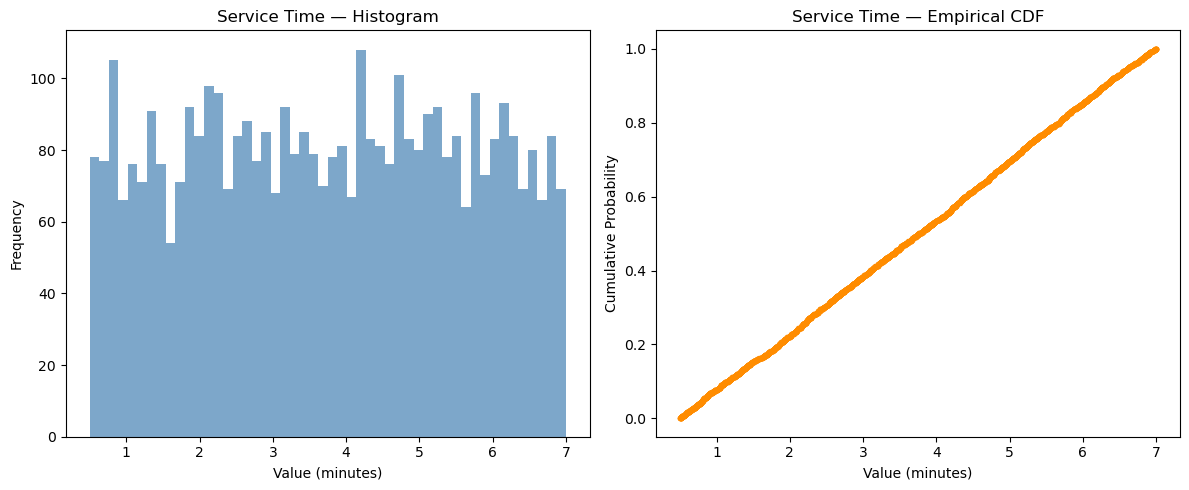

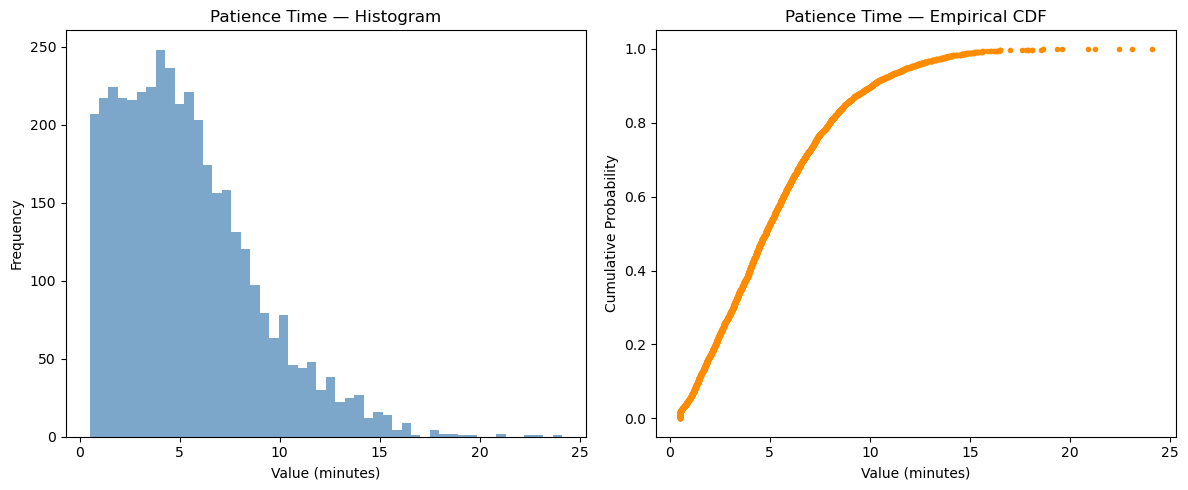

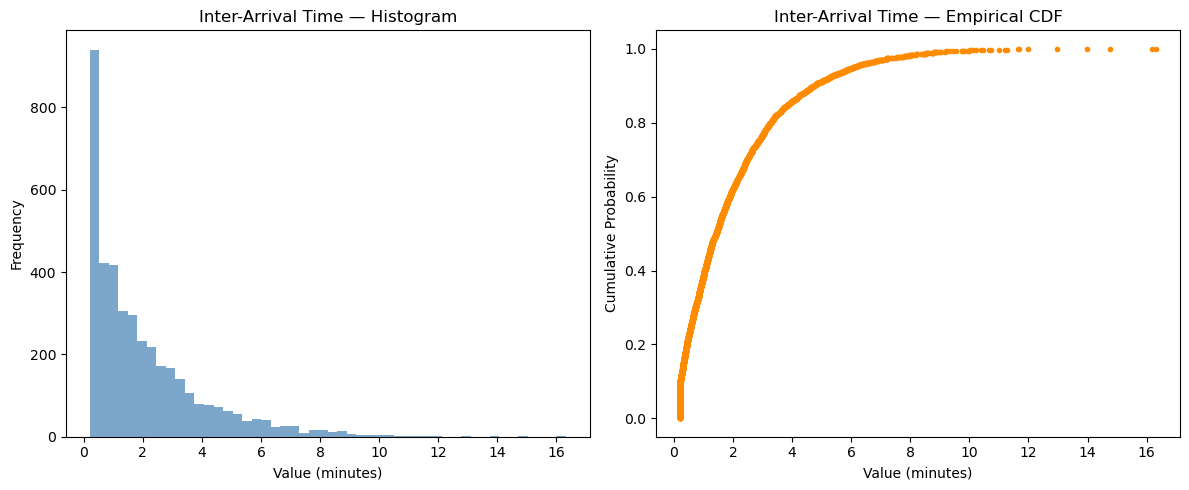

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(data, title, bins=50):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=bins, alpha=0.7, color='steelblue')
    plt.title(f"{title} — Histogram")
    plt.xlabel("Value (minutes)")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
    plt.plot(sorted_data, yvals, marker='.', linestyle='none', color='darkorange')
    plt.title(f"{title} — Empirical CDF")
    plt.xlabel("Value (minutes)")
    plt.ylabel("Cumulative Probability")
    plt.tight_layout()
    plt.show()

plot_distribution(empirical_service_times, "Service Time")
plot_distribution(empirical_patience_times, "Patience Time")
plot_distribution(empirical_interarrival_times, "Inter-Arrival Time")


In [2]:
# ============================================
# Cell 2 — Setup: performance matrix, topics, baseline
# ============================================
import numpy as np
import pandas as pd

# Agent–Problem performance (Laplace smoothing)
def build_agent_problem_performance(df, alpha=1.0, beta=1.0):
    g = df.groupby(["Agent","Topic"])["Resolved"].agg(["sum","count"]).reset_index()
    perf = {}
    for _, r in g.iterrows():
        a, p = r["Agent"], r["Topic"]
        rate = (r["sum"] + alpha) / (r["count"] + alpha + beta) if r["count"] > 0 else alpha/(alpha+beta)
        perf.setdefault(a, {})[p] = float(rate)
    return perf

agent_problem_performance = build_agent_problem_performance(df_cleaned, alpha=1, beta=1)
agent_names = sorted(agent_problem_performance.keys())

# Topic distribution from data
topic_vals = df_cleaned["Topic"].dropna().values
unique_topics, topic_counts = np.unique(topic_vals, return_counts=True)
topic_probs = topic_counts / topic_counts.sum()
topic_to_idx = {t:i for i,t in enumerate(unique_topics)}

def sample_problem_type(rng):
    return rng.choice(unique_topics, p=topic_probs)

# Baseline policy: best available agent by historical resolve rate (with backoff to global mean)
def baseline_policy(problem_type, available_agents, perf):
    if not available_agents:
        return None
    global_mean = np.mean([perf[a].get(problem_type, 0.0) for a in perf if problem_type in perf[a]] or [0.0])
    return max(available_agents, key=lambda a: perf.get(a, {}).get(problem_type, global_mean))

# Topic difficulty multiplier from AvgTalkDuration (0.7..1.4), else flat 1.0
def _to_minutes(series):
    s = series
    if pd.api.types.is_numeric_dtype(s):          return pd.to_numeric(s, errors="coerce").astype(float)
    if pd.api.types.is_timedelta64_dtype(s):      return s.dt.total_seconds()/60.0
    dt = pd.to_datetime(s, errors="coerce", format="%H:%M:%S", exact=False)
    if dt.notna().any():                          return (dt.dt.hour*60 + dt.dt.minute + dt.dt.second/60.0).astype(float)
    td = pd.to_timedelta(s.astype(str), errors="coerce")
    return td.dt.total_seconds()/60.0

if "AvgTalkDuration" in df_cleaned.columns:
    mins = _to_minutes(df_cleaned["AvgTalkDuration"])
    df_tmp = pd.DataFrame({"Topic": df_cleaned["Topic"], "_avg": mins}).dropna()
    if not df_tmp.empty:
        mu = df_tmp.groupby("Topic")["_avg"].mean()
        center = float(mu.mean())
        topic_service_multiplier = {t: float(np.clip(mu.get(t, center)/center, 0.7, 1.4)) for t in unique_topics}
    else:
        topic_service_multiplier = {t: 1.0 for t in unique_topics}
else:
    topic_service_multiplier = {t: 1.0 for t in unique_topics}

print("=== Setup ready ===")
print(f"Agents: {len(agent_names)} | Topics: {len(unique_topics)} | topic_probs sum: {topic_probs.sum():.4f}")
print("Perf sample (first agent):",
      pd.Series(agent_problem_performance[agent_names[0]]).sort_values(ascending=False).head(5).to_dict()
      if agent_names else {})


=== Setup ready ===
Agents: 8 | Topics: 5 | topic_probs sum: 1.0000
Perf sample (first agent): {'Technical Support': 0.900990099009901, 'Admin Support': 0.8921568627450981, 'Contract related': 0.8876404494382022, 'Payment related': 0.8771929824561403, 'Streaming': 0.8760330578512396}


In [3]:
# ============================================
# Cell 3 — Realistic simulator (Top-4 realism)
# ============================================
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def patience_hazard_from_samples(patience_minutes, max_min=180, bin_size=1.0):
    samples = np.asarray(patience_minutes, dtype=float)
    samples = samples[np.isfinite(samples)]
    samples = samples[(samples >= 0.0) & (samples <= 1e6)]
    if samples.size == 0:
        return np.full(int(max_min/bin_size), 0.01, dtype=float)
    grid = np.arange(0.0, max_min + bin_size, bin_size)
    S = np.array([(samples > t).mean() for t in grid])
    S = np.maximum.accumulate(S[::-1])[::-1]
    S = np.clip(S, 1e-6, 1.0)
    h = 1.0 - (S[1:] / S[:-1])
    return np.clip(h, 0.0, 1.0)

class EmpiricalCallCenterSimulator:
    """
    Event-driven simulator using empirical samples, with realism:
      - Peaks by hour + day-of-week, optional holidays, bursts
      - Staffing: per-agent shifts & breaks
      - Service realism: topic difficulty + agent skill + ACW wrap
      - Abandonment via hazard from empirical patience
    API:
      simulate_day(policy, perf) -> events DataFrame
      report(df_events)          -> metrics Series
    """
    def __init__(
        self,
        service_times, patience_times, interarrival_times,
        sim_start, sim_end, agent_names, seed=0,

        # realism knobs
        arrival_scale=1.0, patience_scale=1.0, service_scale=1.0,
        hourly_rate=None, dow_mult=None, holidays=None,
        daily_load_jitter=0.0, burst_prob=0.05, burst_scale=0.4,
        shifts=None, breaks=None,
        topic_service_multiplier=None, acw_minutes=(0.3, 1.5), skill_speed_effect=True,
        hazard_max_min=180, hazard_bin_size=1.0,
        min_interarrival_minutes=1e-6, clip_service_to=(0.5, 60.0), clip_patience_to=(0.5, 120.0),
    ):
        self.rng = np.random.default_rng(seed)
        self.base_service = np.asarray(service_times, dtype=float)
        self.base_patience = np.asarray(patience_times, dtype=float)
        self.base_interarr = np.asarray(interarrival_times, dtype=float)

        self.sim_start, self.sim_end = sim_start, sim_end
        self.agent_names = list(agent_names)

        self.arrival_scale = float(arrival_scale)
        self.patience_scale = float(patience_scale)
        self.service_scale  = float(service_scale)

        self.hourly_rate = hourly_rate or {9:1.0, 10:1.4, 11:1.6, 12:1.2, 13:1.05, 14:1.15, 15:1.45, 16:1.30}
        self.dow_mult    = dow_mult or {0:1.20, 1:1.10, 2:1.00, 3:1.00, 4:0.95, 5:0.70, 6:0.50}
        self.holidays    = holidays or set()
        self.daily_load_jitter = float(daily_load_jitter)
        self.day_mult = float(np.exp(self.rng.normal(0.0, self.daily_load_jitter))) if self.daily_load_jitter>0 else 1.0
        self.burst_prob  = float(burst_prob)
        self.burst_scale = float(burst_scale)

        self.shifts = shifts or {a: [(9.0, 17.0)] for a in self.agent_names}
        self.breaks = breaks or {a: [(11.0, 11.25), (15.0, 15.25)] for a in self.agent_names}

        self.topic_service_multiplier = topic_service_multiplier or {t:1.0 for t in unique_topics}
        self.acw_minutes = tuple(acw_minutes)
        self.skill_speed_effect = bool(skill_speed_effect)

        self.hazard = patience_hazard_from_samples(self.base_patience * self.patience_scale,
                                                   max_min=hazard_max_min, bin_size=hazard_bin_size)
        self.hazard_dt = float(hazard_bin_size)

        self.min_interarrival_minutes = float(min_interarrival_minutes)
        self.clip_service_to  = clip_service_to
        self.clip_patience_to = clip_patience_to

    # gates
    def _on_shift(self, a, h):  return any(s <= h < e for (s,e) in self.shifts.get(a, []))
    def _on_break(self, a, h):  return any(s <= h < e for (s,e) in self.breaks.get(a, []))

    # arrivals
    def _hour_factor(self, dt): return float(self.hourly_rate.get(dt.hour, 0.6))
    def _dow_factor(self, dt):
        if (dt.year, dt.month, dt.day) in self.holidays: return 0.1
        return float(self.dow_mult.get(dt.weekday(), 1.0))
    def _draw_interarrival(self, now):
        ia = float(self.rng.choice(self.base_interarr)) * self.arrival_scale
        ia /= max(self._hour_factor(now) * self._dow_factor(now) * self.day_mult, 1e-6)
        if self.rng.random() < self.burst_prob: ia *= self.burst_scale
        return max(ia, self.min_interarrival_minutes)

    # service & patience
    def _agent_skill_multiplier(self, agent, problem, perf):
        if not self.skill_speed_effect: return 1.0
        r = float(perf.get(agent, {}).get(problem, 0.5))
        return float(np.interp(r, [0.0, 1.0], [1.15, 0.85]))   # better skill → faster
    def _draw_service(self, problem_type, agent=None, perf=None):
        sv = float(self.rng.choice(self.base_service)) * self.service_scale
        sv *= float(self.topic_service_multiplier.get(problem_type, 1.0))
        if agent is not None and perf is not None:
            sv *= self._agent_skill_multiplier(agent, problem_type, perf)
        if self.clip_service_to is not None:
            lo, hi = self.clip_service_to; sv = max(lo, min(hi, sv))
        return max(sv, 0.0)
    def _draw_patience(self):
        pt = float(self.rng.choice(self.base_patience)) * self.patience_scale
        if self.clip_patience_to is not None:
            lo, hi = self.clip_patience_to; pt = max(lo, min(hi, pt))
        return max(pt, 0.0)

    # abandonment via hazard stepping across delta time
    def _abandon_over_delta(self, call, delta_min):
        steps = max(1, int(np.ceil(delta_min / self.hazard_dt)))
        step = delta_min / steps
        for _ in range(steps):
            t = int(min(max(np.floor(call["wait_time"]), 0), len(self.hazard)-1))
            if self.rng.random() < self.hazard[t]:
                return True
            call["wait_time"] += step
        return False

    # main simulation
    def simulate_day(self, policy, perf):
        now = self.sim_start
        events, queue = [], []
        free_at = {a: self.sim_start for a in self.agent_names}

        while now < self.sim_end:
            ia = self._draw_interarrival(now)
            now = now + timedelta(minutes=ia)
            if now >= self.sim_end: break

            prob = sample_problem_type(self.rng)
            call = {
                "arrival_time": now,
                "service_time": None,  # set on assignment (depends on agent + topic)
                "patience_time": self._draw_patience(),
                "problem_type": prob,
                "status": None, "assigned_agent": None,
                "wait_time": 0.0, "resolved": False
            }
            queue.append(call)

            new_queue = []
            h_now = now.hour + now.minute/60.0
            for c in queue:
                available = [a for a in self.agent_names
                             if (now >= free_at[a]) and self._on_shift(a, h_now) and not self._on_break(a, h_now)]
                if available:
                    agent = policy(c["problem_type"], available, perf)
                    if agent is None:
                        if self._abandon_over_delta(c, ia): c["status"]="abandoned"; events.append(c)
                        else: new_queue.append(c)
                        continue

                    c["assigned_agent"] = agent
                    c["status"] = "answered"
                    c["wait_time"] = (now - c["arrival_time"]).total_seconds()/60.0

                    sv = self._draw_service(c["problem_type"], agent, perf)
                    c["service_time"] = sv

                    p_res = float(perf.get(agent, {}).get(c["problem_type"], 0.0))
                    c["resolved"] = (self.rng.random() < p_res)

                    wrap = self.rng.uniform(*self.acw_minutes)
                    free_at[agent] = now + timedelta(minutes=sv + wrap)
                    events.append(c)
                else:
                    if self._abandon_over_delta(c, ia): c["status"]="abandoned"; events.append(c)
                    else: new_queue.append(c)
            queue = new_queue

        for c in queue:
            c["status"] = "abandoned"; events.append(c)
        return pd.DataFrame(events)

    @staticmethod
    def report(df_events):
        total = len(df_events)
        ans = df_events[df_events["status"]=="answered"]
        abd = df_events[df_events["status"]=="abandoned"]
        res = ans[ans["resolved"]==True]
        asa = ans["wait_time"].mean() if not ans.empty else 0.0
        sla20 = (ans["wait_time"] <= (20/60)).mean()*100 if not ans.empty else 0.0
        p90 = ans["wait_time"].quantile(0.90) if not ans.empty else 0.0
        return pd.Series({
            "Total Calls": total,
            "Answered": len(ans), "Abandoned": len(abd), "Resolved": len(res),
            "Answered %": (len(ans)/total*100) if total else 0.0,
            "Abandoned %": (len(abd)/total*100) if total else 0.0,
            "Resolved % of Answered": (len(res)/len(ans)*100) if len(ans) else 0.0,
            "ASA (min)": asa, "SLA 20s %": sla20, "P90 Wait (min)": p90,
            "Avg Service (min)": ans["service_time"].mean() if not ans.empty else 0.0,
        })

print("=== Simulator ready ===")


=== Simulator ready ===


=== Summary stats ===
[Service (empirical)] n=4054  mean=3.749  std=1.856  p50=3.767  p90=6.300  min=0.500  max=7.000
[Service (raw)] n=4054  mean=3.749  std=1.856  p50=3.767  p90=6.300  min=0.500  max=7.000
[Patience (empirical)] n=4054  mean=5.356  std=3.426  p50=4.797  p90=10.097  min=0.500  max=24.126
[Inter-arrival (empirical)] n=4054  mean=2.039  std=1.978  p50=1.427  p90=4.750  min=0.200  max=16.325


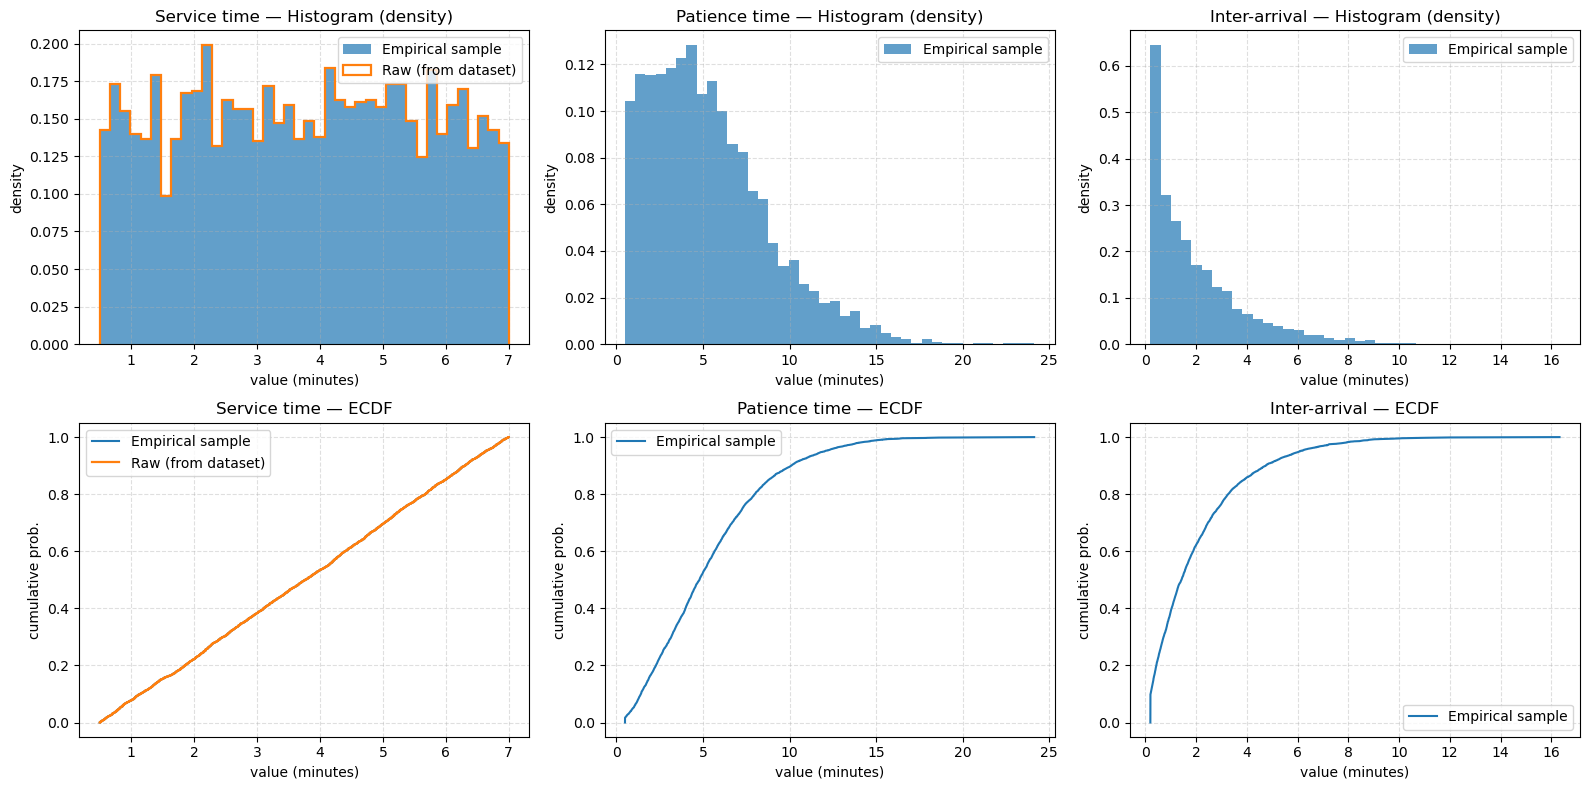

In [12]:
# ============================================
# Cell A — Distribution diagnostics for service, patience, inter-arrival
# - Plots histogram (density) + ECDF
# - Prints summary stats
# - Uses empirical_* arrays; optionally overlays raw columns if present
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ecdf(x):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    x = np.sort(x)
    y = np.arange(1, len(x)+1) / float(len(x)) if len(x) else np.array([])
    return x, y

def summarize(name, arr):
    arr = np.asarray(arr, dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        print(f"[{name}] No data.")
        return
    print(f"[{name}] n={arr.size}  mean={arr.mean():.3f}  std={arr.std(ddof=1):.3f}  "
          f"p50={np.percentile(arr,50):.3f}  p90={np.percentile(arr,90):.3f}  "
          f"min={arr.min():.3f}  max={arr.max():.3f}")

def plot_one(ax_hist, ax_ecdf, data, raw=None, title="", units="min", bins=40):
    data = np.asarray(data, dtype=float)
    data = data[~np.isnan(data)]
    if data.size == 0:
        ax_hist.text(0.5,0.5,"No data", ha="center", va="center", transform=ax_hist.transAxes)
        ax_ecdf.text(0.5,0.5,"No data", ha="center", va="center", transform=ax_ecdf.transAxes)
        return

    # Histogram (density)
    ax_hist.hist(data, bins=bins, density=True, alpha=0.7, label="Empirical sample")
    if raw is not None:
        raw = np.asarray(raw, dtype=float)
        raw = raw[~np.isnan(raw)]
        if raw.size:
            ax_hist.hist(raw, bins=bins, density=True, histtype="step", linewidth=1.6, label="Raw (from dataset)")
    ax_hist.set_title(f"{title} — Histogram (density)")
    ax_hist.set_xlabel(f"value ({units})")
    ax_hist.set_ylabel("density")
    ax_hist.grid(True, ls="--", alpha=0.4)
    ax_hist.legend()

    # ECDF
    x, y = ecdf(data)
    ax_ecdf.plot(x, y, label="Empirical sample")
    if raw is not None:
        raw = np.asarray(raw, dtype=float)
        raw = raw[~np.isnan(raw)]
        if raw.size:
            xr, yr = ecdf(raw)
            ax_ecdf.plot(xr, yr, linewidth=1.6, label="Raw (from dataset)")
    ax_ecdf.set_title(f"{title} — ECDF")
    ax_ecdf.set_xlabel(f"value ({units})")
    ax_ecdf.set_ylabel("cumulative prob.")
    ax_ecdf.grid(True, ls="--", alpha=0.4)
    ax_ecdf.legend()

# ---- Wire up the available arrays/columns ----
# Required: empirical_* arrays must exist
emp_svc = np.asarray(empirical_service_times, dtype=float)
emp_pat = np.asarray(empirical_patience_times, dtype=float)
emp_ia  = np.asarray(empirical_interarrival_times, dtype=float)

# Optional raw columns (change these if your column names differ)
raw_service   = df_cleaned['ServiceMinutes'].values if 'ServiceMinutes' in df_cleaned.columns else None
raw_patience  = df_cleaned['PatienceMinutes'].values if 'PatienceMinutes' in df_cleaned.columns else None
# Inter-arrival raw only if you computed it into df_cleaned (not all datasets have it)
raw_interarr  = df_cleaned['InterarrivalMinutes'].values if 'InterarrivalMinutes' in df_cleaned.columns else None

# ---- Print summaries ----
print("=== Summary stats ===")
summarize("Service (empirical)", emp_svc)
if raw_service is not None: summarize("Service (raw)", raw_service)

summarize("Patience (empirical)", emp_pat)
if raw_patience is not None: summarize("Patience (raw)", raw_patience)

summarize("Inter-arrival (empirical)", emp_ia)
if raw_interarr is not None: summarize("Inter-arrival (raw)", raw_interarr)

# ---- Plots: 2x3 grid (hist + ECDF for each metric) ----
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

plot_one(axes[0,0], axes[1,0], emp_svc, raw=raw_service,   title="Service time",     units="minutes", bins=40)
plot_one(axes[0,1], axes[1,1], emp_pat, raw=raw_patience,  title="Patience time",    units="minutes", bins=40)
plot_one(axes[0,2], axes[1,2], emp_ia,  raw=raw_interarr,  title="Inter-arrival",    units="minutes", bins=40)

plt.tight_layout()
plt.show()


In [4]:
# ============================================
# Cell 4 — Arrival calibration helper (optional)
# Finds arrival_scale to hit a target mean arrivals/day
# ============================================
from datetime import datetime

def estimate_arrivals_for_scale(arrival_scale, sim_kwargs, trials=6, seed0=12345):
    cnt = []
    for i in range(trials):
        sim = EmpiricalCallCenterSimulator(**{**sim_kwargs, "arrival_scale": arrival_scale}, seed=seed0+i)
        ev = sim.simulate_day(baseline_policy, agent_problem_performance)
        cnt.append(len(ev))
    return np.mean(cnt)

def calibrate_arrival_scale(target_arrivals, sim_kwargs, start=1.0, max_iter=12):
    # simple multiplicative search
    scale = start
    for _ in range(max_iter):
        est = estimate_arrivals_for_scale(scale, sim_kwargs)
        if est <= 1e-9:   # avoid divide by zero
            scale *= 0.5
            continue
        ratio = target_arrivals / est
        # dampen jumps
        scale *= np.clip(ratio, 0.6, 1.6)
        if abs(est - target_arrivals) / target_arrivals < 0.05:
            break
    return scale

print("=== Arrival calibration helper ready ===")


=== Arrival calibration helper ready ===


In [5]:
# ============================================
# Cell 5 — Q-learning: state/action space + trainer + Q preview
# ============================================
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# State: (time_bin, queue_len_bin, free_agents_count, top_problem_idx_or_none)
TIME_BINS   = 8
QUEUE_BINS  = [0,1,3,5,10,20,50]
RANK_K      = 3
HOLD_IDX    = RANK_K
PROBLEM_PLUS1 = len(unique_topics) + 1
MAX_FREE    = len(agent_names)

def encode_state(now, queue, free_agents, sim_start, sim_end):
    span = (sim_end - sim_start).total_seconds()
    pos  = (now - sim_start).total_seconds()
    tbin = int(np.floor((pos / max(span,1e-9)) * TIME_BINS))
    tbin = min(max(tbin,0), TIME_BINS-1)
    qbin = int(np.digitize([len(queue)], QUEUE_BINS)[0])
    free_c = len(free_agents)
    if len(queue) == 0:
        top_idx = PROBLEM_PLUS1 - 1
    else:
        prob = queue[0]['problem_type']
        top_idx = int(np.where(unique_topics == prob)[0][0]) if prob in unique_topics else PROBLEM_PLUS1 - 1
    return ((tbin*(len(QUEUE_BINS)+1) + qbin)*(MAX_FREE+1) + min(free_c, MAX_FREE)) * PROBLEM_PLUS1 + top_idx

S = TIME_BINS * (len(QUEUE_BINS)+1) * (MAX_FREE+1) * PROBLEM_PLUS1
A = RANK_K + 1  # rank#1..rank#K + HOLD

def rank_agents(problem, available_agents, perf):
    if (problem is None) or (not available_agents): return []
    global_mean = np.mean([perf[a].get(problem, 0.0) for a in perf if problem in perf[a]] or [0.0])
    scored = [(a, perf.get(a, {}).get(problem, global_mean)) for a in available_agents]
    scored.sort(key=lambda x: x[1], reverse=True)
    return [a for a,_ in scored]

class QTrainer:
    def __init__(self, agent_names, perf, alpha=0.15, gamma=0.97,
                 eps_start=0.35, eps_end=0.02, eps_decay_days=120, seed=2025, rank_k=RANK_K):
        self.agent_names = list(agent_names)
        self.perf = perf
        self.alpha, self.gamma = alpha, gamma
        self.eps_start, self.eps_end, self.eps_decay_days = eps_start, eps_end, eps_decay_days
        self.rank_k = rank_k
        self.rng = np.random.default_rng(seed)
        self.Q = np.zeros((S, A), dtype=float)

    def epsilon(self, day_idx):
        if self.eps_decay_days <= 0: return self.eps_end
        frac = min(1.0, day_idx / self.eps_decay_days)
        return self.eps_end + (self.eps_start - self.eps_end) * np.exp(-3*frac)

    def train_one_day(self, day_idx, sim_kwargs):
        eps = self.epsilon(day_idx)
        sim = EmpiricalCallCenterSimulator(**sim_kwargs, seed=10_000 + day_idx)
        rng = sim.rng
        now = sim.sim_start
        queue = []
        free_at = {a: sim.sim_start for a in self.agent_names}
        day_reward = 0.0

        while now < sim.sim_end:
            ia = sim._draw_interarrival(now)
            now = now + timedelta(minutes=ia)
            if now >= sim.sim_end: break

            prob = sample_problem_type(rng)
            queue.append({
                'arrival_time': now,
                'service_time': None,
                'patience_time': sim._draw_patience(),
                'problem_type': prob,
                'wait_time': 0.0
            })

            free_agents = [a for a in self.agent_names if now >= free_at[a]]
            s = encode_state(now, queue, free_agents, sim.sim_start, sim.sim_end)

            ranked = rank_agents(queue[0]['problem_type'] if queue else None, free_agents, self.perf)
            k_avail = min(len(ranked), self.rank_k)
            valid = list(range(k_avail)) + [HOLD_IDX]

            # epsilon-greedy
            if (len(valid)==0) or (self.rng.random() < eps):
                a = HOLD_IDX if len(valid)==0 else int(self.rng.choice(valid))
            else:
                q_vals = np.array([self.Q[s, ai] for ai in valid])
                a = int(valid[int(np.argmax(q_vals))])

            reward = 0.0
            if a != HOLD_IDX and k_avail > 0:
                agent = ranked[a]
                c0 = queue.pop(0)
                sv = sim._draw_service(c0['problem_type'], agent, self.perf)
                p_res = self.perf.get(agent, {}).get(c0['problem_type'], 0.0)
                resolved = (rng.random() < p_res)
                reward += (10.0 if resolved else 2.0)
                wrap = rng.uniform(*sim.acw_minutes)
                free_at[agent] = now + timedelta(minutes=sv + wrap)
            # abandonment step for remaining calls
            still = []
            for c in queue:
                if sim._abandon_over_delta(c, ia): reward -= 5.0
                else: still.append(c)
            queue = still

            sp = encode_state(now, queue, [a for a in self.agent_names if now >= free_at[a]], sim.sim_start, sim.sim_end)
            best_next = np.max(self.Q[sp, :])
            self.Q[s, a] = (1 - self.alpha)*self.Q[s, a] + self.alpha*(reward + self.gamma*best_next)
            day_reward += reward

        return day_reward

    def train(self, days=365, sim_kwargs=None, log_q_curve=True):
        rewards = []
        q_curve = [float(self.Q.mean())] if log_q_curve else None
        for d in range(days):
            r = self.train_one_day(d, sim_kwargs)
            rewards.append(r)
            if log_q_curve: q_curve.append(float(self.Q.mean()))
        return (rewards, q_curve) if log_q_curve else (rewards, None)

    def act(self, now, queue, free_agents):
        s = encode_state(now, queue, free_agents, sim_start, sim_end)
        ranked = rank_agents(queue[0]['problem_type'] if queue else None, free_agents, self.perf)
        k_avail = min(len(ranked), self.rank_k)
        valid = list(range(k_avail)) + [HOLD_IDX]
        if not valid: return HOLD_IDX, ranked
        q_vals = np.array([self.Q[s, ai] for ai in valid])
        a = int(valid[int(np.argmax(q_vals))])
        return a, ranked

# Helpers to preview a small slice of Q-table
action_labels = [f"rank#{i+1}" for i in range(RANK_K)] + ["HOLD"]
def topic_name_from_idx(top_idx):
    return "NO-QUEUE" if top_idx == (PROBLEM_PLUS1 - 1) else str(unique_topics[min(top_idx, len(unique_topics)-1)])

def preview_q_table(Q, max_rows=20):
    rows = []
    example_tbins  = [0, TIME_BINS//2]
    example_qbins  = list(range(min(4, len(QUEUE_BINS)+1)))
    example_free   = sorted(set([0, 1, min(3, MAX_FREE), MAX_FREE]))
    example_topics = [0, PROBLEM_PLUS1 - 1]
    for tbin in example_tbins:
        for qbin in example_qbins:
            for free_c in example_free:
                for top_idx in example_topics:
                    s = ((tbin*(len(QUEUE_BINS)+1) + qbin)*(MAX_FREE+1) + min(free_c, MAX_FREE)) * PROBLEM_PLUS1 + top_idx
                    row = {
                        "state_idx": s,
                        "time_bin": tbin,
                        "queue_bin": qbin,
                        "free_agents": free_c,
                        "top_problem": topic_name_from_idx(top_idx),
                    }
                    for ai, lab in enumerate(action_labels):
                        row[f"Q[{lab}]"] = float(Q[s, ai])
                    rows.append(row)
    return pd.DataFrame(rows).sort_values(by=["time_bin","queue_bin","free_agents","top_problem"]).reset_index(drop=True).head(max_rows)

print("=== Q-learning trainer ready ===")


=== Q-learning trainer ready ===


In [9]:
# ============================================
# DEFINE: QTrainerWithDiag (standalone)
# - Tabular Q-learning with diagnostics:
#   * epsilon & alpha decay
#   * reward scaling
#   * logs avg Q (all states), avg Q (visited states), mean |TD error|
# ============================================
import numpy as np
from datetime import timedelta

# Safety checks for required globals
_required = ["EmpiricalCallCenterSimulator", "encode_state", "rank_agents",
             "agent_problem_performance", "agent_names", "sim_start", "sim_end",
             "RANK_K", "HOLD_IDX"]
_missing = [x for x in _required if x not in globals()]
if _missing:
    raise RuntimeError(f"Missing required definitions before trainer: {_missing}")

# Derive state/action sizes from existing globals
if "TIME_BINS" not in globals(): TIME_BINS = 8
if "QUEUE_BINS" not in globals(): QUEUE_BINS = [0,1,3,5,10,20,50]
if "unique_topics" not in globals():
    raise RuntimeError("unique_topics not found. Define topics in your setup cell.")
PROBLEM_PLUS1 = len(unique_topics) + 1
MAX_FREE = len(agent_names)
S = TIME_BINS * (len(QUEUE_BINS)+1) * (MAX_FREE+1) * PROBLEM_PLUS1
A = RANK_K + 1  # rank#1..rank#K + HOLD

class QTrainerWithDiag:
    def __init__(self, agent_names, perf, gamma=0.97,
                 alpha=0.15, alpha_min=0.02, alpha_decay_days=1200,
                 eps_start=0.35, eps_end=0.01, eps_decay_days=1500,
                 reward_scale=0.1, seed=2025, rank_k=RANK_K):
        self.agent_names = list(agent_names)
        self.perf = perf
        self.gamma = float(gamma)

        # learning/exploration schedules
        self.alpha0 = float(alpha)
        self.alpha_min = float(alpha_min)
        self.alpha_decay_days = int(alpha_decay_days)
        self.eps_start = float(eps_start)
        self.eps_end   = float(eps_end)
        self.eps_decay_days = int(eps_decay_days)

        self.reward_scale = float(reward_scale)
        self.rank_k = int(rank_k)
        self.rng = np.random.default_rng(seed)

        self.Q = np.zeros((S, A), dtype=float)
        self.visited_states = set()

    def epsilon(self, day_idx):
        frac = min(1.0, day_idx / max(self.eps_decay_days, 1))
        return self.eps_end + (self.eps_start - self.eps_end) * np.exp(-3.0*frac)

    def alpha_t(self, day_idx):
        frac = min(1.0, day_idx / max(self.alpha_decay_days, 1))
        return self.alpha_min + (self.alpha0 - self.alpha_min) * np.exp(-3.0*frac)

    def train_one_day(self, day_idx, sim_kwargs):
        eps = self.epsilon(day_idx)
        alpha = self.alpha_t(day_idx)

        sim = EmpiricalCallCenterSimulator(**sim_kwargs, seed=10_000 + day_idx)
        rng = sim.rng
        now = sim.sim_start
        queue = []
        free_at = {a: sim.sim_start for a in self.agent_names}

        day_reward = 0.0
        td_errors = []

        while now < sim.sim_end:
            ia = sim._draw_interarrival(now)
            now = now + timedelta(minutes=ia)
            if now >= sim.sim_end: break

            # arrival
            prob = sample_problem_type(rng)
            queue.append({
                'arrival_time': now,
                'service_time': None,
                'patience_time': sim._draw_patience(),
                'problem_type': prob,
                'wait_time': 0.0
            })

            free_agents = [a for a in self.agent_names if now >= free_at[a]]
            s = encode_state(now, queue, free_agents, sim.sim_start, sim.sim_end)
            self.visited_states.add(s)

            ranked = rank_agents(queue[0]['problem_type'] if queue else None, free_agents, self.perf)
            k_avail = min(len(ranked), self.rank_k)
            valid = list(range(k_avail)) + [HOLD_IDX]

            # epsilon-greedy
            if (len(valid)==0) or (rng.random() < eps):
                a = HOLD_IDX if len(valid)==0 else int(rng.choice(valid))
            else:
                q_vals = np.array([self.Q[s, ai] for ai in valid])
                a = int(valid[int(np.argmax(q_vals))])

            reward = 0.0
            if a != HOLD_IDX and k_avail > 0:
                agent = ranked[a]
                c0 = queue.pop(0)
                sv = sim._draw_service(c0['problem_type'], agent, self.perf)
                p_res = self.perf.get(agent, {}).get(c0['problem_type'], 0.0)
                resolved = (rng.random() < p_res)
                reward += (10.0 if resolved else 2.0)
                wrap = rng.uniform(*sim.acw_minutes)
                free_at[agent] = now + timedelta(minutes=sv + wrap)

            # abandonment over the inter-arrival delta
            still = []
            for c in queue:
                if sim._abandon_over_delta(c, ia): reward -= 5.0
                else: still.append(c)
            queue = still

            # TD update
            sp = encode_state(now, queue, [a for a in self.agent_names if now >= free_at[a]], sim.sim_start, sim.sim_end)
            best_next = np.max(self.Q[sp, :])
            target = (reward * self.reward_scale) + self.gamma * best_next
            td = target - self.Q[s, a]
            self.Q[s, a] += alpha * td
            td_errors.append(abs(td))
            day_reward += reward

        return day_reward, (np.mean(td_errors) if td_errors else 0.0)

    def train(self, days=1500, sim_kwargs=None, log_q_curve=True):
        rewards = []
        q_curve_all = [float(self.Q.mean())] if log_q_curve else None
        q_curve_vis = [np.nan]
        td_curve = []

        for d in range(days):
            r, td = self.train_one_day(d, sim_kwargs)
            rewards.append(r)
            if log_q_curve:
                q_curve_all.append(float(self.Q.mean()))
                if self.visited_states:
                    q_curve_vis.append(float(self.Q[list(self.visited_states)].mean()))
                else:
                    q_curve_vis.append(np.nan)
            td_curve.append(td)

        return rewards, q_curve_all, q_curve_vis, td_curve

    def act(self, now, queue, free_agents):
        s = encode_state(now, queue, free_agents, sim_start, sim_end)
        ranked = rank_agents(queue[0]['problem_type'] if queue else None, free_agents, self.perf)
        k_avail = min(len(ranked), self.rank_k)
        valid = list(range(k_avail)) + [HOLD_IDX]
        if not valid: return HOLD_IDX, ranked
        q_vals = np.array([self.Q[s, ai] for ai in valid])
        a = int(valid[int(np.argmax(q_vals))])
        return a, ranked


Q-table initialised: shape = (3456, 4)  (states=3456, actions=4)
Actions: ['rank#1', 'rank#2', 'rank#3', 'HOLD']

Q-table preview (selected states, BEFORE training):
    state_idx  time_bin  queue_bin  free_agents    top_problem  Q[rank#1]  \
0           0         0          0            0  Admin Support        0.0   
1           5         0          0            0       NO-QUEUE        0.0   
2           6         0          0            1  Admin Support        0.0   
3          11         0          0            1       NO-QUEUE        0.0   
4          18         0          0            3  Admin Support        0.0   
5          23         0          0            3       NO-QUEUE        0.0   
6          48         0          0            8  Admin Support        0.0   
7          53         0          0            8       NO-QUEUE        0.0   
8          54         0          1            0  Admin Support        0.0   
9          59         0          1            0       NO-QUEUE  

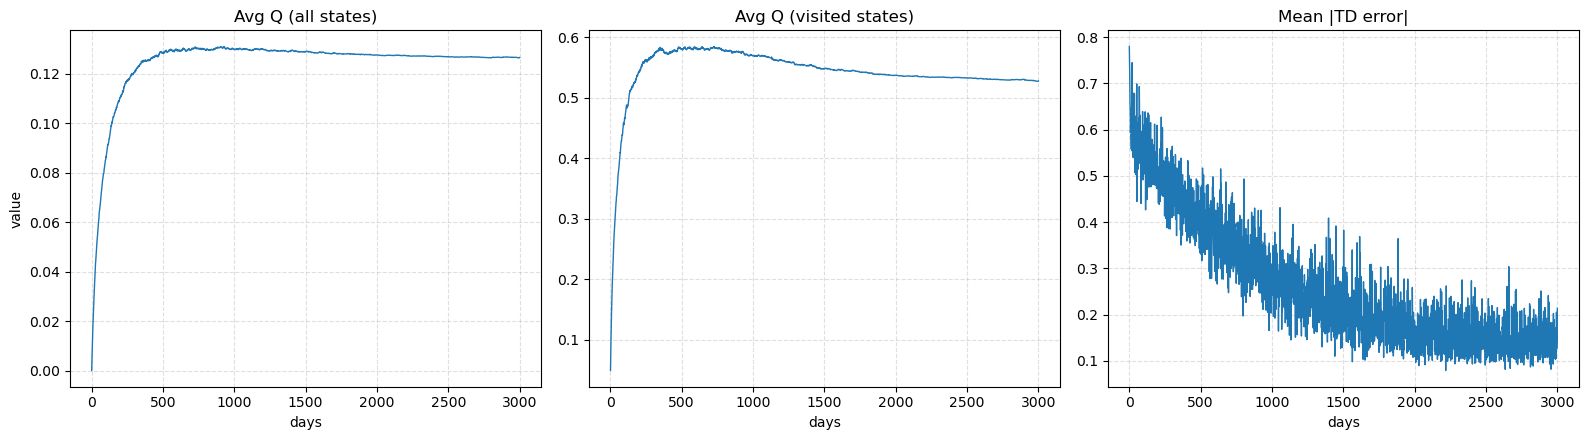


Q-table preview (selected states, AFTER training):
    state_idx  time_bin  queue_bin  free_agents    top_problem  Q[rank#1]  \
0           0         0          0            0  Admin Support   0.000000   
1           5         0          0            0       NO-QUEUE   0.000000   
2           6         0          0            1  Admin Support   0.000000   
3          11         0          0            1       NO-QUEUE   0.000000   
4          18         0          0            3  Admin Support   0.000000   
5          23         0          0            3       NO-QUEUE   0.000000   
6          48         0          0            8  Admin Support   0.000000   
7          53         0          0            8       NO-QUEUE   0.000000   
8          54         0          1            0  Admin Support   0.000000   
9          59         0          1            0       NO-QUEUE   0.000000   
10         60         0          1            1  Admin Support   0.000000   
11         65         0 

In [10]:
# ============================================
# Cell 6 — Train MDP: Q-table before/after + convergence plot
# ============================================
import matplotlib.pyplot as plt
from datetime import datetime

# 1) World definitions (edit as needed)
sim_start = datetime(2025, 1, 1, 9, 0)
sim_end   = datetime(2025, 1, 1, 17, 0)

# Stationary training world (helps convergence)
sim_kwargs_train = dict(
    service_times=empirical_service_times,
    patience_times=empirical_patience_times,
    interarrival_times=empirical_interarrival_times,
    sim_start=sim_start, sim_end=sim_end,
    agent_names=agent_names,
    arrival_scale=1.0,
    patience_scale=1.0,
    service_scale=1.0,
    daily_load_jitter=0.0,
    burst_prob=0.0,
    topic_service_multiplier=topic_service_multiplier,
    clip_service_to=(0.5, 60.0),
    clip_patience_to=(0.5, 120.0)
)

# Realistic evaluation world (peaks + jitter + bursts)
sim_kwargs_eval = sim_kwargs_train.copy()
sim_kwargs_eval.update({
    "daily_load_jitter": 0.20,
    "burst_prob": 0.05,
    "burst_scale": 0.4
})

# 2) Trainer + Q-table BEFORE
trainer = QTrainer(agent_names, agent_problem_performance,
                   alpha=0.15, gamma=0.97,
                   eps_start=0.35, eps_end=0.02, eps_decay_days=120, seed=2025)

print(f"Q-table initialised: shape = {trainer.Q.shape}  (states={trainer.Q.shape[0]}, actions={trainer.Q.shape[1]})")
print("Actions:", action_labels)
print("\nQ-table preview (selected states, BEFORE training):")
print(preview_q_table(trainer.Q, max_rows=20))

# 3) Train
# ============================================
# Train for 3000 days (stationary world) + convergence diagnostics
# Requires: EmpiricalCallCenterSimulator, encode_state, rank_agents,
#           topic_service_multiplier, agent_problem_performance, agent_names,
#           sim_start, sim_end, and QTrainerWithDiag (from earlier cell).
# ============================================
import matplotlib.pyplot as plt
from datetime import timedelta

# ---- Stationary training world (keep strictly stationary to aid convergence) ----
sim_kwargs_train = dict(
    service_times=empirical_service_times,
    patience_times=empirical_patience_times,
    interarrival_times=empirical_interarrival_times,
    sim_start=sim_start, sim_end=sim_end,
    agent_names=agent_names,
    arrival_scale=1.0,
    patience_scale=1.0,
    service_scale=1.0,
    daily_load_jitter=0.0,   # <- no jitter during training
    burst_prob=0.0,          # <- no bursts during training
    topic_service_multiplier=topic_service_multiplier,
    clip_service_to=(0.5, 60.0),
    clip_patience_to=(0.5, 120.0),
)

# ---- Recreate trainer (alpha & epsilon decay tuned for long runs) ----
trainer = QTrainerWithDiag(
    agent_names, agent_problem_performance,
    gamma=0.97,
    alpha=0.15, alpha_min=0.02, alpha_decay_days=2400,   # slower decay over 3000d
    eps_start=0.35, eps_end=0.005, eps_decay_days=2500,  # explore longer, but taper to 0.5%
    reward_scale=0.1,
    seed=2025
)

# ---- Train 3000 days ----
TRAIN_DAYS = 3000
rewards, avg_q_all, avg_q_vis, td_abs = trainer.train(
    days=TRAIN_DAYS, sim_kwargs=sim_kwargs_train, log_q_curve=True
)
print("Training complete. Last 10 day rewards:", [round(x,2) for x in rewards[-10:]])
print(f"Visited states: {len(trainer.visited_states)} / {trainer.Q.shape[0]} total")
print(f"Avg Q (all states): start={avg_q_all[0]:.6f}  end={avg_q_all[-1]:.6f}")

# ---- Plot diagnostics: all-states avg Q, visited-states avg Q, mean |TD error| ----
fig, ax = plt.subplots(1,3, figsize=(16,4.5))

ax[0].plot(range(len(avg_q_all)), avg_q_all, lw=1)
ax[0].set_title("Avg Q (all states)")
ax[0].set_xlabel("days"); ax[0].set_ylabel("value"); ax[0].grid(True, ls='--', alpha=0.4)

ax[1].plot(range(len(avg_q_vis)), avg_q_vis, lw=1)
ax[1].set_title("Avg Q (visited states)")
ax[1].set_xlabel("days"); ax[1].grid(True, ls='--', alpha=0.4)

ax[2].plot(range(len(td_abs)), td_abs, lw=1)
ax[2].set_title("Mean |TD error|")
ax[2].set_xlabel("days"); ax[2].grid(True, ls='--', alpha=0.4)

plt.tight_layout(); plt.show()


# 5) Q-table AFTER
print("\nQ-table preview (selected states, AFTER training):")
print(preview_q_table(trainer.Q, max_rows=20))
print(f"\nAverage Q AFTER: {trainer.Q.mean():.6f}  | Max: {trainer.Q.max():.6f} | Min: {trainer.Q.min():.6f}")


In [16]:
# ============================================
# Cell 7 — Evaluate: baseline vs MDP in realistic world
# ============================================
from datetime import timedelta

def simulate_one_day_state_aware(seed, policy="mdp"):
    sim = EmpiricalCallCenterSimulator(**sim_kwargs_eval, seed=seed)
    rng = sim.rng
    now = sim_start
    queue = []
    free_at = {a: sim_start for a in agent_names}
    arrivals = answered = abandoned = resolved = 0
    wait_sum = service_sum = 0.0

    while now < sim_end:
        ia = sim._draw_interarrival(now)
        now = now + timedelta(minutes=ia)
        if now >= sim_end: break

        prob = sample_problem_type(rng)
        queue.append({
            'arrival_time': now,
            'service_time': None,
            'patience_time': sim._draw_patience(),
            'problem_type': prob,
            'wait_time': 0.0
        })
        arrivals += 1

        new_queue = []
        for c in queue:
            h_now = now.hour + now.minute/60.0
            free_agents = [a for a in agent_names if (now >= free_at[a]) and sim._on_shift(a, h_now) and not sim._on_break(a, h_now)]
            if free_agents:
                if policy == "mdp":
                    a_idx, ranked = trainer.act(now, queue, free_agents)
                    if a_idx == HOLD_IDX or len(ranked)==0:
                        if sim._abandon_over_delta(c, ia): abandoned += 1
                        else: new_queue.append(c)
                        continue
                    agent = ranked[min(a_idx, len(ranked)-1)]
                else:
                    agent = baseline_policy(c['problem_type'], free_agents, agent_problem_performance)

                c['wait_time'] = (now - c['arrival_time']).total_seconds()/60.0
                answered += 1
                wait_sum += c['wait_time']

                sv = sim._draw_service(c['problem_type'], agent, agent_problem_performance)
                service_sum += sv
                wrap = rng.uniform(*sim.acw_minutes)
                free_at[agent] = now + timedelta(minutes=sv + wrap)

                p_res = agent_problem_performance.get(agent, {}).get(c['problem_type'], 0.0)
                if rng.random() < p_res: resolved += 1
            else:
                if sim._abandon_over_delta(c, ia): abandoned += 1
                else: new_queue.append(c)
        queue = new_queue

    abandoned += len(queue)

    return {
        "Arrivals": arrivals,
        "Answered": answered,
        "Abandoned": abandoned,
        "Resolved": resolved,
        "Answered %": (answered/arrivals*100) if arrivals else 0.0,
        "Abandoned %": (abandoned/arrivals*100) if arrivals else 0.0,
        "Avg Wait (min)": (wait_sum/answered) if answered else 0.0,
        "Avg Service (min)": (service_sum/answered) if answered else 0.0,
        "Reward": resolved*10 + (answered-resolved)*2 - abandoned*5
    }

# Compare across N realistic days
EVAL_DAYS = 365
rows = []
BASE_SEED = 50_000
for d in range(EVAL_DAYS):
    seed = BASE_SEED + d
    rows.append({"policy":"Greedy", **simulate_one_day_state_aware(seed, "greedy")})
    rows.append({"policy":"MDP",    **simulate_one_day_state_aware(seed, "mdp")})
df_daily = pd.DataFrame(rows)

print("\nDaily results (first 6 rows):")
print(df_daily.head(6))
summary = df_daily.groupby("policy").agg(['mean','std'])
print("\nSummary (mean ± std):")
print(summary[['Abandoned %','Answered %','Avg Wait (min)','Arrivals','Reward']])



Daily results (first 6 rows):
   policy  Arrivals  Answered  Abandoned  Resolved  Answered %  Abandoned %  \
0  Greedy       276       255         21       234   92.391304     7.608696   
1     MDP       276       255         21       233   92.391304     7.608696   
2  Greedy       354       337         17       311   95.197740     4.802260   
3     MDP       364       342         22       312   93.956044     6.043956   
4  Greedy       347       331         16       308   95.389049     4.610951   
5     MDP       343       320         23       299   93.294461     6.705539   

   Avg Wait (min)  Avg Service (min)  Reward  
0        0.049925           3.256340    2277  
1        0.049925           3.261721    2269  
2        0.068298           3.396715    3077  
3        0.097753           3.398105    3070  
4        0.108967           3.324833    3046  
5        0.161243           3.310619    2917  

Summary (mean ± std):
       Abandoned %           Answered %           Avg Wait (min

=== Summary (means over days) ===
        Avg Wait (min)    Reward  Satisfaction %
policy                                          
Greedy           0.132  2666.803          91.715
MDP              0.141  2650.225          91.228


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


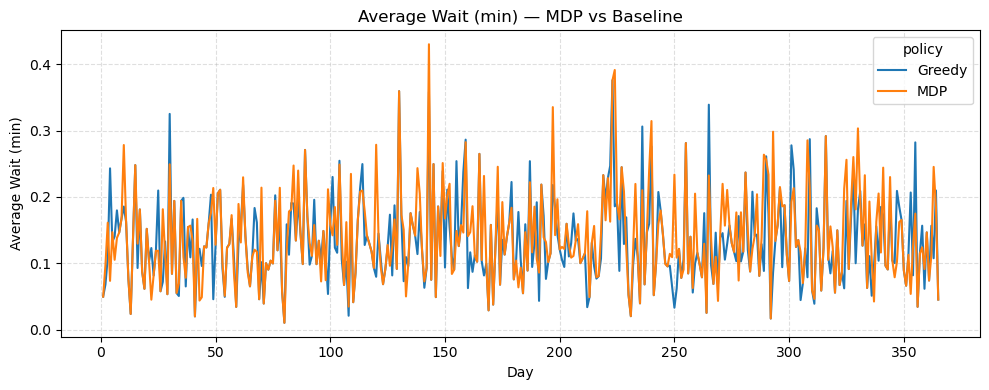

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


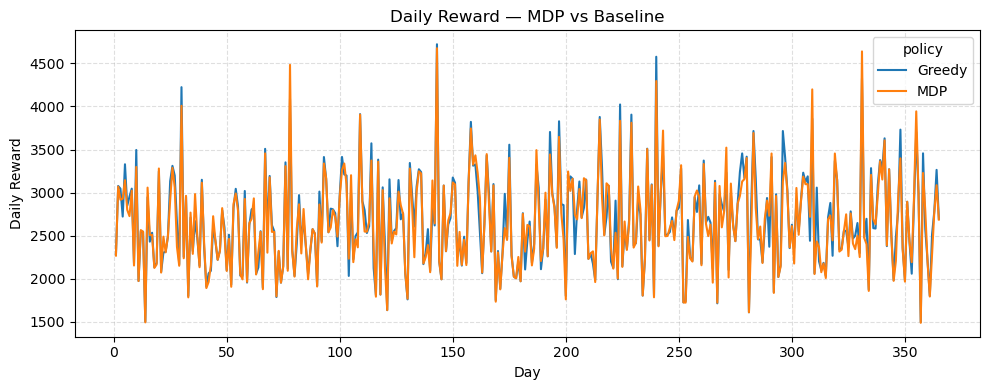

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


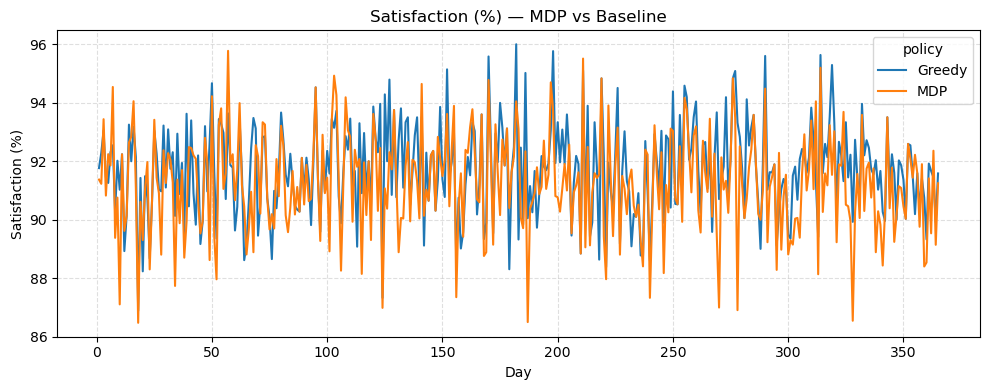

In [18]:
# ============================================
#
 — Avg Wait, Reward, Satisfaction (daily series + summary)
# Requires: df_daily with columns ['policy','Answered','Resolved','Reward','Avg Wait (min)']
# ============================================
import numpy as np
import matplotlib.pyplot as plt

# Try seaborn; fall back to pure matplotlib if unavailable
try:
    import seaborn as sns
    HAVE_SNS = True
except Exception:
    HAVE_SNS = False

# Ensure df_daily exists
if 'df_daily' not in locals():
    raise RuntimeError("df_daily not found. Run the evaluation cell first.")

# Add a 'day' column if missing (pairs of rows: Greedy, MDP per day)
if 'day' not in df_daily.columns:
    n_pairs = len(df_daily) // 2
    df_daily = df_daily.copy()
    df_daily['day'] = np.repeat(np.arange(1, n_pairs + 1), 2)

# Compute Satisfaction %
df_daily = df_daily.copy()
df_daily['Satisfaction %'] = np.where(
    df_daily['Answered'] > 0,
    (df_daily['Resolved'] / df_daily['Answered']) * 100.0,
    0.0
)

# Quick summary table
summary = (
    df_daily
    .groupby('policy')[['Avg Wait (min)', 'Reward', 'Satisfaction %']]
    .mean()
    .round(3)
)
print("=== Summary (means over days) ===")
print(summary)

# Plot helpers
def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(10, 4))
    if HAVE_SNS:
        sns.lineplot(data=df, x='day', y=metric, hue='policy', linewidth=1.5)
    else:
        # Fallback: pure matplotlib
        for policy, d in df.groupby('policy'):
            plt.plot(d['day'].values, d[metric].values, label=policy, linewidth=1.5)
        plt.legend()
    plt.title(f"{ylabel} — MDP vs Baseline")
    plt.xlabel("Day")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Time-series plots
plot_metric(df_daily, 'Avg Wait (min)', 'Average Wait (min)')
plot_metric(df_daily, 'Reward', 'Daily Reward')
plot_metric(df_daily, 'Satisfaction %', 'Satisfaction (%)')



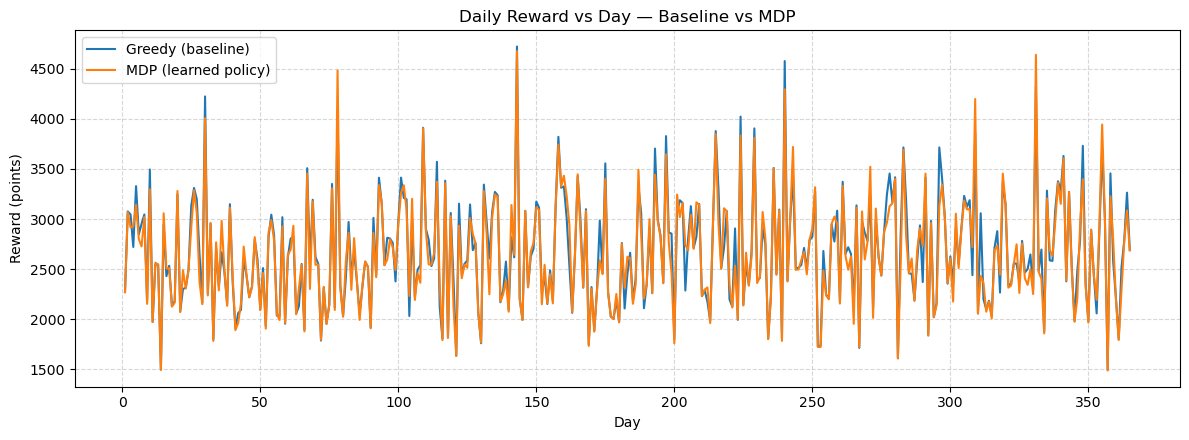

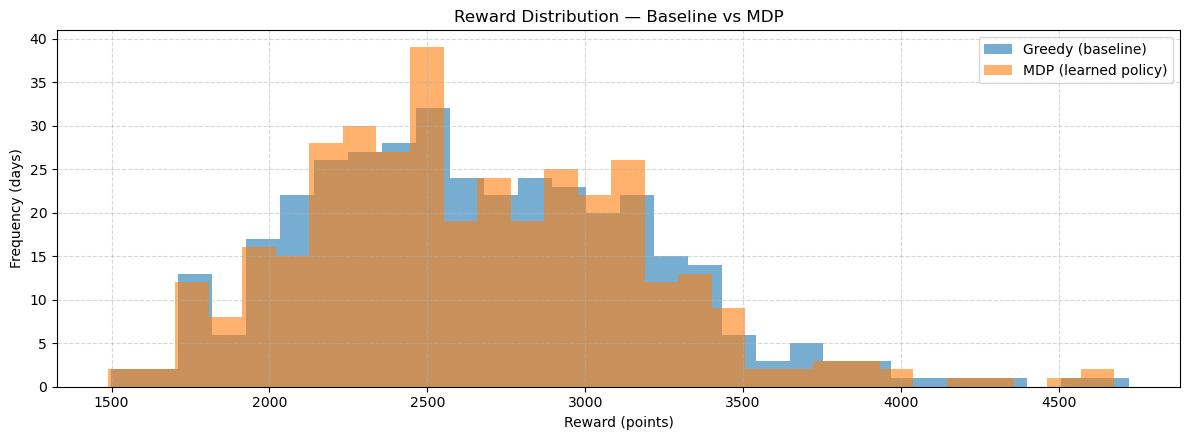

In [19]:
# --- Daily reward by policy: line plot + histograms ---
import numpy as np
import matplotlib.pyplot as plt

# Safety check
if 'df_daily' not in globals():
    raise RuntimeError("df_daily not found. Run your MDP vs Baseline evaluation cell first.")

# Add a per-policy day index so lines align correctly
df_rewards = df_daily[['policy','Reward']].copy()
df_rewards['day'] = df_rewards.groupby('policy').cumcount() + 1

# Split by policy
g = df_rewards[df_rewards['policy']=='Greedy'].sort_values('day')
m = df_rewards[df_rewards['policy']=='MDP'].sort_values('day')

# ---- Line: reward vs day ----
plt.figure(figsize=(12,4.5))
plt.plot(g['day'], g['Reward'], label='Greedy (baseline)', linewidth=1.5)
plt.plot(m['day'], m['Reward'], label='MDP (learned policy)', linewidth=1.5)
plt.title("Daily Reward vs Day — Baseline vs MDP")
plt.xlabel("Day")
plt.ylabel("Reward (points)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("fig_reward_line_baseline_vs_mdp.png", dpi=200, bbox_inches="tight")

# ---- Histograms: reward distribution by policy ----
plt.figure(figsize=(12,4.5))
bins = 30
plt.hist(g['Reward'], bins=bins, alpha=0.6, label='Greedy (baseline)')
plt.hist(m['Reward'], bins=bins, alpha=0.6, label='MDP (learned policy)')
plt.title("Reward Distribution — Baseline vs MDP")
plt.xlabel("Reward (points)")
plt.ylabel("Frequency (days)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("fig_reward_hist_baseline_vs_mdp.png", dpi=200, bbox_inches="tight")


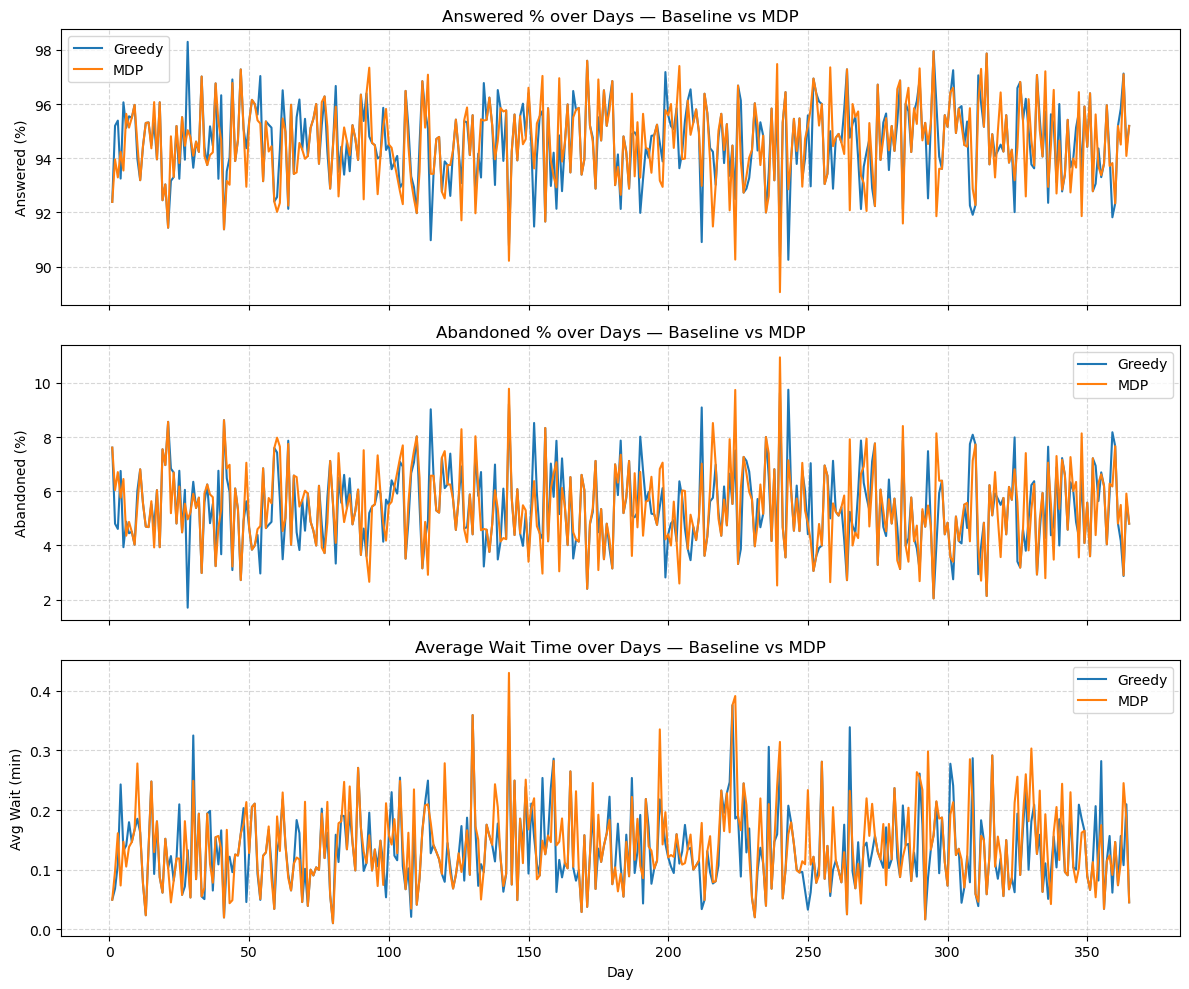

In [20]:
# --- Time-series comparison: Answered %, Abandoned %, Avg Wait (min) ---
import matplotlib.pyplot as plt

# Safety check
req_cols = {'policy','Answered %','Abandoned %','Avg Wait (min)'}
if 'df_daily' not in globals() or not req_cols.issubset(df_daily.columns):
    raise RuntimeError("df_daily missing required columns. Run your evaluation cell first.")

df_ts = df_daily[['policy','Answered %','Abandoned %','Avg Wait (min)']].copy()
df_ts['day'] = df_ts.groupby('policy').cumcount() + 1

g = df_ts[df_ts['policy']=='Greedy'].sort_values('day')
m = df_ts[df_ts['policy']=='MDP'].sort_values('day')

fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)

# Answered %
axes[0].plot(g['day'], g['Answered %'], label='Greedy', linewidth=1.5)
axes[0].plot(m['day'], m['Answered %'], label='MDP', linewidth=1.5)
axes[0].set_title("Answered % over Days — Baseline vs MDP")
axes[0].set_ylabel("Answered (%)")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# Abandoned %
axes[1].plot(g['day'], g['Abandoned %'], label='Greedy', linewidth=1.5)
axes[1].plot(m['day'], m['Abandoned %'], label='MDP', linewidth=1.5)
axes[1].set_title("Abandoned % over Days — Baseline vs MDP")
axes[1].set_ylabel("Abandoned (%)")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# Avg Wait
axes[2].plot(g['day'], g['Avg Wait (min)'], label='Greedy', linewidth=1.5)
axes[2].plot(m['day'], m['Avg Wait (min)'], label='MDP', linewidth=1.5)
axes[2].set_title("Average Wait Time over Days — Baseline vs MDP")
axes[2].set_xlabel("Day")
axes[2].set_ylabel("Avg Wait (min)")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

plt.tight_layout()
plt.show()
# fig.savefig("fig_timeseries_baseline_vs_mdp.png", dpi=200, bbox_inches="tight")


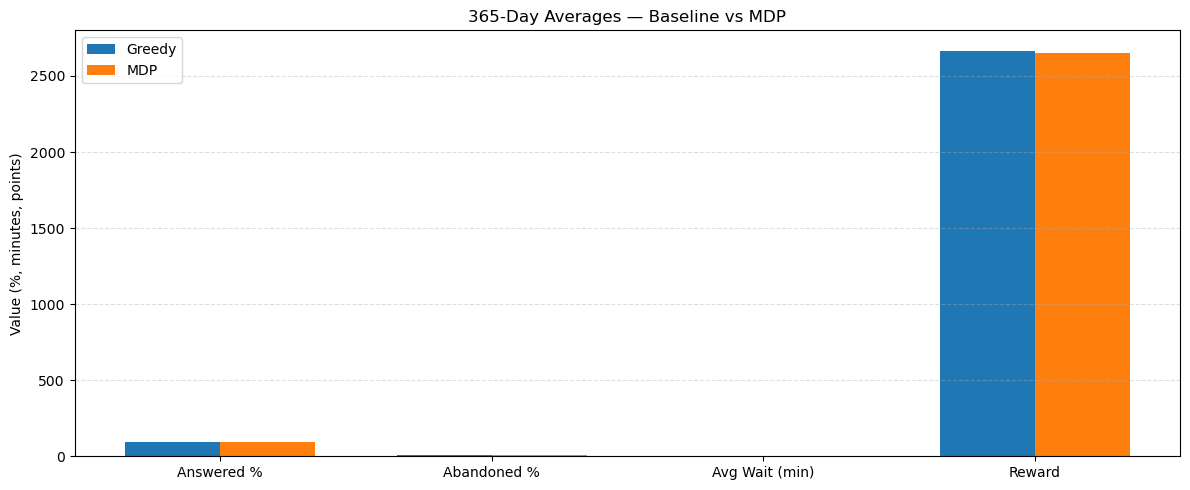

In [21]:
# --- Side-by-side bar chart of 365-day means by policy ---
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Answered %','Abandoned %','Avg Wait (min)','Reward']
means = df_daily.groupby('policy')[metrics].mean().reindex(['Greedy','MDP'])
errs  = df_daily.groupby('policy')[metrics].std().reindex(['Greedy','MDP'])  # std as error bars (optional)

plt.figure(figsize=(12,5))
x = np.arange(len(metrics))
w = 0.35

plt.bar(x - w/2, means.loc['Greedy'].values, width=w, label='Greedy')
plt.bar(x + w/2, means.loc['MDP'].values,  width=w, label='MDP')
# Optional error bars:
# plt.errorbar(x - w/2, means.loc['Greedy'].values, yerr=errs.loc['Greedy'].values, fmt='none', ecolor='black', capsize=3)
# plt.errorbar(x + w/2, means.loc['MDP'].values,  yerr=errs.loc['MDP'].values,  fmt='none', ecolor='black', capsize=3)

plt.xticks(x, metrics)
plt.ylabel("Value (%, minutes, points)")
plt.title("365-Day Averages — Baseline vs MDP")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("fig_means_baseline_vs_mdp.png", dpi=200, bbox_inches="tight")


In [22]:
# Per-call logging evaluation for Baseline vs MDP (state-aware, same engine)
from datetime import timedelta
import numpy as np
import pandas as pd

# Safety checks
req_syms = ['EmpiricalCallCenterSimulator', 'sim_kwargs_eval', 'agent_names',
            'agent_problem_performance', 'baseline_policy', 'trainer',
            'sample_problem_type', 'sim_start', 'sim_end', 'HOLD_IDX']
missing = [s for s in req_syms if s not in globals()]
if missing:
    raise RuntimeError(f"Missing symbols: {missing}. Run your simulator + MDP training cells first.")

def eval_one_day_with_calls(seed, policy="mdp"):
    sim = EmpiricalCallCenterSimulator(**sim_kwargs_eval, seed=seed)
    rng = sim.rng
    now = sim_start
    queue = []
    free_at = {a: sim_start for a in agent_names}

    events = []  # per-call logs

    while now < sim_end:
        ia = sim._draw_interarrival(now)
        now = now + timedelta(minutes=ia)
        if now >= sim_end: break

        prob = sample_problem_type(rng)
        # create a new "call" object we’ll carry through
        call = {
            'arrival_time': now,
            'service_time': sim._draw_service(prob),
            'patience_time': sim._draw_patience(),
            'problem_type': prob,
            'wait_time': 0.0,
        }
        queue.append(call)

        new_queue = []
        for c in queue:
            h_now = now.hour + now.minute/60.0
            free_agents = [a for a in agent_names
                           if (now >= free_at[a]) and sim._on_shift(a, h_now) and not sim._on_break(a, h_now)]

            if free_agents:
                if policy == "mdp":
                    a_idx, ranked = trainer.act(now, queue, free_agents)
                    if a_idx == HOLD_IDX or len(ranked)==0:
                        # still waiting
                        if sim._abandon_over_delta(c, ia):
                            # abandon event
                            events.append({
                                'policy': 'MDP',
                                'problem_type': c['problem_type'],
                                'wait_time': c['wait_time'] + ia,
                                'service_time': 0.0,
                                'agent': None,
                                'resolved': False,
                                'abandoned': True,
                                'reward': -5.0
                            })
                        else:
                            c['wait_time'] += ia
                            new_queue.append(c)
                        continue
                    agent = ranked[min(a_idx, len(ranked)-1)]
                else:  # greedy baseline
                    agent = baseline_policy(c['problem_type'], free_agents, agent_problem_performance)
                    if agent is None:
                        if sim._abandon_over_delta(c, ia):
                            events.append({
                                'policy': 'Greedy',
                                'problem_type': c['problem_type'],
                                'wait_time': c['wait_time'] + ia,
                                'service_time': 0.0,
                                'agent': None,
                                'resolved': False,
                                'abandoned': True,
                                'reward': -5.0
                            })
                        else:
                            c['wait_time'] += ia
                            new_queue.append(c)
                        continue

                # Answer the call
                w = (now - c['arrival_time']).total_seconds()/60.0
                p_res = agent_problem_performance.get(agent, {}).get(c['problem_type'], 0.0)
                resolved = (rng.random() < p_res)

                # Wrap-up + occupy agent
                wrap = rng.uniform(*sim.acw_minutes)
                free_at[agent] = now + timedelta(minutes=c['service_time'] + wrap)

                # Reward per call (as in your project): +10 resolved, +2 answered-unresolved, -5 abandoned
                rew = 10.0 if resolved else 2.0

                events.append({
                    'policy': 'MDP' if policy == 'mdp' else 'Greedy',
                    'problem_type': c['problem_type'],
                    'wait_time': w,
                    'service_time': c['service_time'],
                    'agent': agent,
                    'resolved': resolved,
                    'abandoned': False,
                    'reward': rew
                })
            else:
                # still waiting
                if sim._abandon_over_delta(c, ia):
                    events.append({
                        'policy': 'MDP' if policy == 'mdp' else 'Greedy',
                        'problem_type': c['problem_type'],
                        'wait_time': c['wait_time'] + ia,
                        'service_time': 0.0,
                        'agent': None,
                        'resolved': False,
                        'abandoned': True,
                        'reward': -5.0
                    })
                else:
                    c['wait_time'] += ia
                    new_queue.append(c)
        queue = new_queue

    # End-of-day: abandon leftovers
    for c in queue:
        events.append({
            'policy': 'MDP' if policy == 'mdp' else 'Greedy',
            'problem_type': c['problem_type'],
            'wait_time': c['wait_time'],
            'service_time': 0.0,
            'agent': None,
            'resolved': False,
            'abandoned': True,
            'reward': -5.0
        })

    return pd.DataFrame(events)

# ---- Run N days and combine per-call logs for both policies ----
EVAL_DAYS = 90  # change if you want more/less resolution
BASE_SEED = 70_000

dfs = []
for d in range(EVAL_DAYS):
    seed = BASE_SEED + d
    dfs.append(eval_one_day_with_calls(seed, policy="greedy"))
    dfs.append(eval_one_day_with_calls(seed, policy="mdp"))

df_calls = pd.concat(dfs, ignore_index=True)
print("Per-call event log built:", df_calls.shape, "rows")
print(df_calls.head())


Per-call event log built: (56671, 8) rows
   policy      problem_type  wait_time  service_time    agent  resolved  \
0  Greedy         Streaming        0.0      5.348817  Stewart      True   
1  Greedy   Payment related        0.0      5.197996     Greg      True   
2  Greedy     Admin Support        0.0      0.709662    Diane      True   
3  Greedy   Payment related        0.0      4.126409     Greg      True   
4  Greedy  Contract related        0.0      4.054589   Martha     False   

   abandoned  reward  
0      False    10.0  
1      False    10.0  
2      False    10.0  
3      False    10.0  
4      False     2.0  


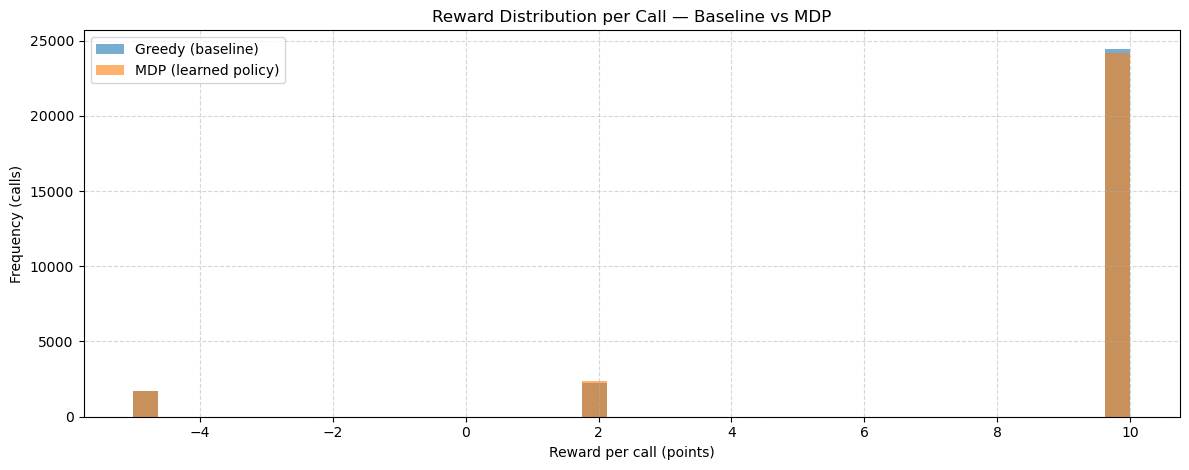

In [23]:
# Reward distribution per call — Baseline vs MDP (Figures 1 & 2)
import matplotlib.pyplot as plt

if 'df_calls' not in globals():
    raise RuntimeError("df_calls not found. Run the per-call logging cell first.")

plt.figure(figsize=(12,4.8))
bins = 40
plt.hist(df_calls[df_calls['policy']=='Greedy']['reward'], bins=bins, alpha=0.6, label='Greedy (baseline)')
plt.hist(df_calls[df_calls['policy']=='MDP']['reward'],    bins=bins, alpha=0.6, label='MDP (learned policy)')
plt.title("Reward Distribution per Call — Baseline vs MDP")
plt.xlabel("Reward per call (points)")
plt.ylabel("Frequency (calls)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



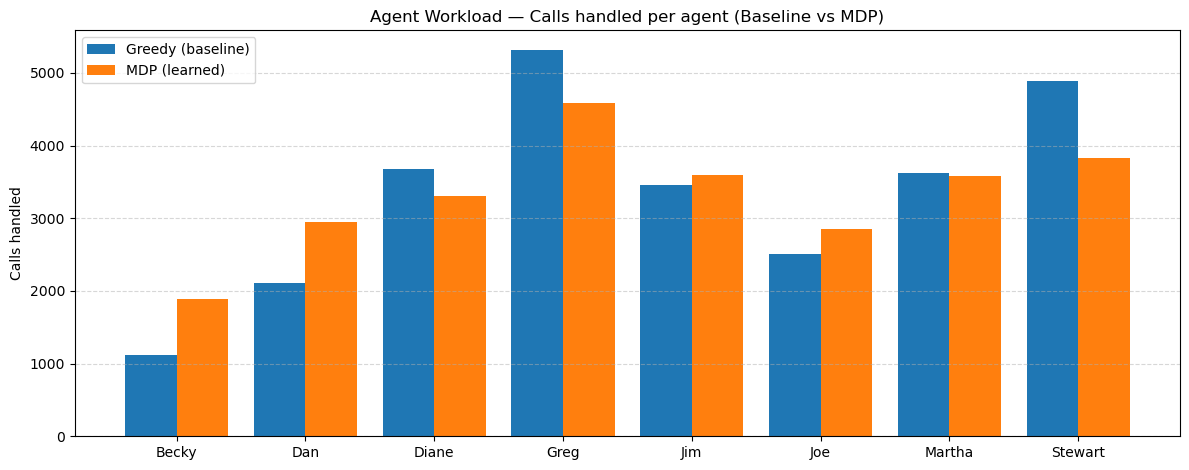

In [24]:
# Agent workload per policy (Figures 3 & 4)
import numpy as np
import matplotlib.pyplot as plt

work = df_calls.dropna(subset=['agent']).groupby(['policy','agent']).size().reset_index(name='calls')
agents = sorted(work['agent'].dropna().unique())
w_g = work[work['policy']=='Greedy'].set_index('agent').reindex(agents)['calls'].fillna(0)
w_m = work[work['policy']=='MDP'].set_index('agent').reindex(agents)['calls'].fillna(0)

x = np.arange(len(agents))
w = 0.4

plt.figure(figsize=(12,4.8))
plt.bar(x - w/2, w_g.values, width=w, label='Greedy (baseline)')
plt.bar(x + w/2, w_m.values, width=w, label='MDP (learned)')
plt.xticks(x, agents, rotation=0)
plt.ylabel("Calls handled")
plt.title("Agent Workload — Calls handled per agent (Baseline vs MDP)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


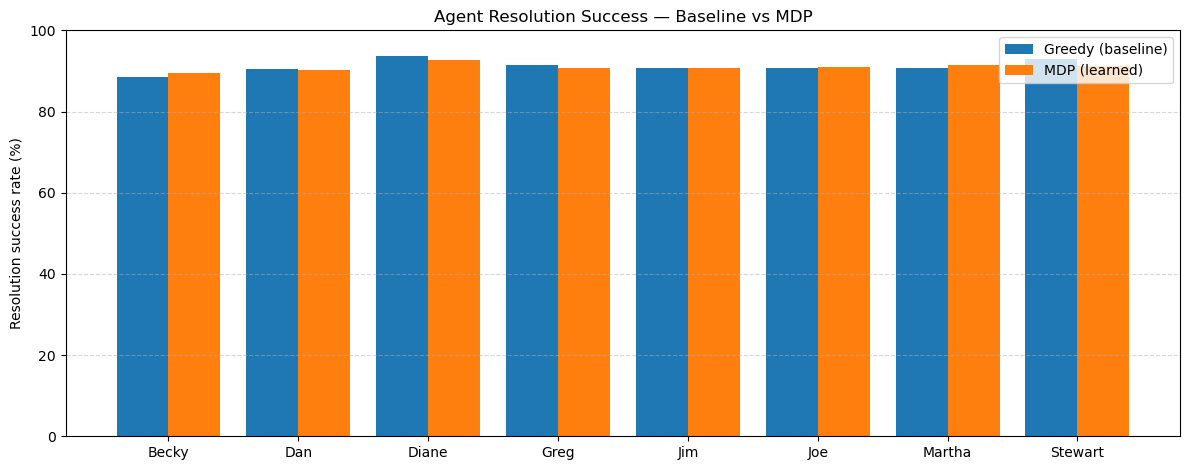

In [26]:
# Agent resolution success rate per policy (Figure 6)
import numpy as np
import matplotlib.pyplot as plt

res = df_calls.dropna(subset=['agent']).groupby(['policy','agent'])['resolved'].mean().reset_index()
agents = sorted(res['agent'].unique())
r_g = res[res['policy']=='Greedy'].set_index('agent').reindex(agents)['resolved'].fillna(0.0) * 100
r_m = res[res['policy']=='MDP'].set_index('agent').reindex(agents)['resolved'].fillna(0.0) * 100

x = np.arange(len(agents))
w = 0.4

plt.figure(figsize=(12,4.8))
plt.bar(x - w/2, r_g.values, width=w, label='Greedy (baseline)')
plt.bar(x + w/2, r_m.values, width=w, label='MDP (learned)')
plt.xticks(x, agents)
plt.ylabel("Resolution success rate (%)")
plt.title("Agent Resolution Success — Baseline vs MDP")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()
